In [2]:
# Import libraries
import psycopg2
import getpass
import matplotlib.pyplot as plt
import numpy as np
import os.path
import time

In [3]:
# load the data
_data = np.load('res/admission.npy', allow_pickle=True).tolist()
adm_labels = _data['adm_labels']
all_adm = _data['all_adm']
first_adm = _data['first_adm']
adult_first_adm = _data['adult_first_adm']
print("Loaded!")

Loaded!


In [4]:
# Create a database connection
user = 'postgres'
host = 'localhost'
port = '5433'
dbname = 'mimic'
schema = 'mimiciii'

In [5]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path TO {}'.format(schema))
con.commit()
print("Connected!")

Password: ··········


Connected!


In [6]:
start = time.time()

# Select GCS (eyes) measurements
query = \
"""
SELECT subject_id, hadm_id, icustay_id, itemid, charttime, valuenum, valueuom
FROM chartevents
WHERE itemid = 184 OR itemid = 220739
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
gcs_eyes = np.array(data)

end = time.time()

# Print run time
print("This query took {} seconds".format(round((end-start),2)))

This query took 10.16 seconds


In [7]:
# Select the different units
query = \
"""
SELECT DISTINCT(valueuom)
FROM chartevents
WHERE itemid = 184 OR itemid = 220739
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
units = np.array(data)

# Display the units
print("Units:")
print(units)

Units:
[[None]]


In [8]:
# Check how many GCS (eyes) measurements are in the data set
print("No. of GCS eye measurements: {}".format(np.shape(gcs_eyes)[0]))
print("No. of 'None' values: {} ({}%)".format(sum(x is None for x in gcs_eyes[:,5]), round(sum(x is None for x in gcs_eyes[:,5])/np.shape(gcs_eyes)[0],4)))

No. of GCS eye measurements: 1521602
No. of 'None' values: 529 (0.0003%)


In [9]:
print("Shape of gcs_eyes before removing None values: {}".format(np.shape(gcs_eyes)))

# Remove None values
gcs_eyes = gcs_eyes[~np.isnan(gcs_eyes[:,5].astype(float))]

print("Shape of gcs_eyes after removing None values: {}".format(np.shape(gcs_eyes)))

Shape of gcs_eyes before removing None values: (1521602, 7)
Shape of gcs_eyes after removing None values: (1521073, 7)


In [10]:
# Select data for hospital admission ID 145834 only
eyes = gcs_eyes[gcs_eyes[:,1]==145834]

In [11]:
# Sort measurements by time
eyes = eyes[eyes[:,4].argsort()]
eyes[:,4] = eyes[:,4] - adult_first_adm[:,-1][adult_first_adm[:,1]==145834] # convert raw times to time since admission
for i in range(len(eyes[:,4])):
    eyes[:,4][i] = eyes[:,4][i].total_seconds()/(60*60)

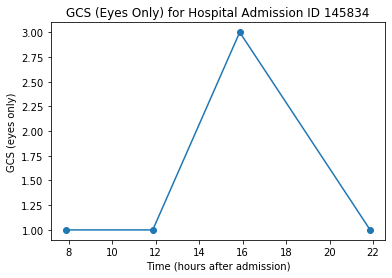

In [12]:
# Plot GCS (eyes) data for hospital admission ID 145834
hrs = 24 # select how many hours post admission to display
plt.plot(eyes[:,4][eyes[:,4]<=hrs], eyes[:,5][eyes[:,4]<=hrs], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('GCS (eyes only)')
plt.title('GCS (Eyes Only) for Hospital Admission ID 145834')
plt.show()

In [13]:
print("No. of measurements in first {} hours: {}".format(hrs,len(eyes[:,4][eyes[:,4]<=hrs])))
print("Total no. of measurements: {}".format(len(eyes[:,4])))

No. of measurements in first 24 hours: 4
Total no. of measurements: 29


In [14]:
# Get mean GCS (eyes) for each hour
processed_eyes = np.zeros((24,2))
for i in range(24):
    eyes_values = eyes[:,5][np.logical_and(eyes[:,4]>=i, eyes[:,4]<(i+1))]
    x = 1
    while len(eyes_values) == 0:
        eyes_values = eyes[:,5][np.logical_and(eyes[:,4]>=(i-x), eyes[:,4]<(i+1+x))]
        x+=1
    mean_eyes = np.mean(eyes_values)
    processed_eyes[i,0] = i+1
    processed_eyes[i,1] = mean_eyes

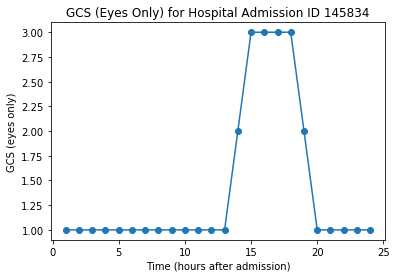

In [15]:
# Plot the processed GCS (eyes) data for hospital admission ID 145834
plt.plot(processed_eyes[:,0], processed_eyes[:,1], marker="o")
plt.xlabel('Time (hours after admission)')
plt.ylabel('GCS (eyes only)')
plt.title('GCS (Eyes Only) for Hospital Admission ID 145834')
plt.show()

In [16]:
# Initialise a 3D numpy array for 24 hour measurements
m = len(adult_first_adm) # number of patients
gcs_eyes_24h = np.zeros((m, 25, 1))

In [17]:
# Create processed 24 hour GCS (eyes) time series for every patient
start = time.time()

for i in range(m):
    
    # Define hospital admission ID number
    admission_id = adult_first_adm[i,1]
    
    # Select data for hospital admission ID
    eyes = gcs_eyes[gcs_eyes[:,1]==admission_id]
    
    # Account for patients with no GCS (eyes) measurements
    if len(eyes) == 0:
        processed_eyes = np.zeros((24,1))
        
    else:
    
        # Sort measurements by time
        admit_time = adult_first_adm[i,-1]
        eyes = eyes[eyes[:,4].argsort()]
        eyes[:,4] = eyes[:,4] - admit_time # convert raw times to time since admission
        for j in range(len(eyes[:,4])):
            eyes[:,4][j] = eyes[:,4][j].total_seconds()/(60*60)
    
        # Get mean GCS (eyes) for each hour
        processed_eyes = np.zeros((24,1))
        for k in range(24):
            eyes_values = eyes[:,5][np.logical_and(eyes[:,4]>=k, eyes[:,4]<(k+1))]
            x = 1
            while len(eyes_values) == 0:
                eyes_values = eyes[:,5][np.logical_and(eyes[:,4]>=(k-x), eyes[:,4]<(k+1+x))]
                x+=1
            mean_eyes = np.mean(eyes_values)
            processed_eyes[k] = mean_eyes
    
    # Store in gcs_eyes_24h
    gcs_eyes_24h[i,0,:] = admission_id
    gcs_eyes_24h[i,1:,:] = processed_eyes
    
    # Print progress
    if (i+1) % 1000 == 0:
        print("{}% complete ({}/{})".format(round((i+1)/m*100,2), i+1, m))

end = time.time()

# Evaluate run time
print("")
print("Finished! This took {} minutes".format(round((end-start)/60,2)))

2.59% complete (1000/38549)
5.19% complete (2000/38549)
7.78% complete (3000/38549)
10.38% complete (4000/38549)
12.97% complete (5000/38549)
15.56% complete (6000/38549)
18.16% complete (7000/38549)
20.75% complete (8000/38549)
23.35% complete (9000/38549)
25.94% complete (10000/38549)
28.54% complete (11000/38549)
31.13% complete (12000/38549)
33.72% complete (13000/38549)
36.32% complete (14000/38549)
38.91% complete (15000/38549)
41.51% complete (16000/38549)
44.1% complete (17000/38549)
46.69% complete (18000/38549)
49.29% complete (19000/38549)
51.88% complete (20000/38549)
54.48% complete (21000/38549)
57.07% complete (22000/38549)
59.66% complete (23000/38549)
62.26% complete (24000/38549)
64.85% complete (25000/38549)
67.45% complete (26000/38549)
70.04% complete (27000/38549)
72.63% complete (28000/38549)
75.23% complete (29000/38549)
77.82% complete (30000/38549)
80.42% complete (31000/38549)
83.01% complete (32000/38549)
85.61% complete (33000/38549)
88.2% complete (34000/3

In [18]:
gcs_eyes_labels = ["subject_id", "hadm_id", "icustay_id", "itemid", "charttime", "valuenum", "valueuom"]

# Save to gcs_eyes.npy
if not os.path.exists('./res'):
    os.makedirs('./res')

tosave = {'gcs_eyes_labels': gcs_eyes_labels, 'gcs_eyes': gcs_eyes, 'gcs_eyes_24h': gcs_eyes_24h}
np.save('res/gcs_eyes.npy',tosave)
print("Saved!")

Saved!
